# Combining QC Tests

As deadlines for v1 of the IQuOD flags approach, we need to decide how best to combine the results of our existing QC tests. In this notebook, we build on previous machine learning trials to measure our current best performance, and propose some additional new QC tests to improve these results. 

The trials below were conducted on 12787 profiles from the *quota* dataset; final results should be validated against the entire thing.

## 1. Machine Learning Strategy

We saw previously that support vector machines and quadradic discriminant analysis made useful decisions on our QC flags; here we emply both and poll the results, flagging a profile if it is flagged by either algorithm.

In [156]:
import pandas, numpy
from sklearn import svm
from sklearn.qda import QDA
from wodpy import wod
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [157]:
results = pandas.read_csv('results-most.csv')

# slice up for machine learning
truth = results.ix[:,1].tolist()
qctests = results.ix[:,2:].values.tolist()

trainingSize = 1000

In [158]:
def performance(truth, qcresult):
    # check the performance of a single column qcresult

    TT = 0.
    FF = 0.
    TF = 0.
    FT = 0.
    T = 0.
    F = 0.
    
    for i in range(len(qcresult)):
        if truth[i]:
            T += 1.
        else:
            F += 1.
        
        if qcresult[i] and truth[i]:
            TT += 1.
        elif qcresult[i] and not truth[i]:
            TF += 1.
        elif not qcresult[i] and truth[i]:
            FT += 1.
        elif not qcresult[i] and not truth[i]:
            FF += 1.
    
    return (TT/T, FT/T, FF/F, TF/F)

In [159]:
for i in range(2,len(qctests[0])):
    print results.columns[i], performance(truth, results.ix[:,i].tolist())

Argo_global_range_check (0.1596244131455399, 0.8403755868544601, 1.0, 0.0)
Argo_gradient_test (0.27386541471048514, 0.7261345852895149, 0.9990945011524531, 0.0009054988475469213)
Argo_impossible_date_test (0.0, 1.0, 1.0, 0.0)
Argo_impossible_location_test (0.0, 1.0, 1.0, 0.0)
Argo_pressure_increasing_test (0.11580594679186229, 0.8841940532081377, 0.866480079025354, 0.13351992097464604)
Argo_regional_range_test (0.006259780907668232, 0.9937402190923318, 0.9999176819229503, 8.231807704972011e-05)
Argo_spike_test (0.0297339593114241, 0.9702660406885759, 1.0, 0.0)
CSIRO_depth (0.837245696400626, 0.162754303599374, 0.2642410273296016, 0.7357589726703985)
CSIRO_gradient (0.4381846635367762, 0.5618153364632238, 0.8554494567006915, 0.14455054329930853)
CSIRO_wire_break (0.2519561815336463, 0.7480438184663537, 1.0, 0.0)
CoTeDe_Argo_density_inversion (0.3489827856025039, 0.651017214397496, 0.5221435627263747, 0.4778564372736253)
CoTeDe_GTSPP_WOA_normbias (0.8497652582159625, 0.15023474178403756,

In [160]:
# create and train an svm

svm_classifier = svm.SVC(kernel='linear', class_weight = {0: 1, 1: 100})
svm_classifier.fit(qctests[0:trainingSize], truth[0:trainingSize])

SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 100}, coef0=0.0, degree=3,
  gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [161]:
# create and train a qda

qda_classifier = QDA()
qda_classifier.fit(qctests[0:trainingSize], truth[0:trainingSize])

QDA(priors=None, reg_param=0.0)

In [162]:
svm_prediction = svm_classifier.predict(qctests[trainingSize:])
qda_prediction = qda_classifier.predict(qctests[trainingSize:])

final_prediction = [ svm_prediction[i] or qda_prediction[i] for i in range(len(svm_prediction))]
performance(truth[trainingSize:], final_prediction)

(0.9069767441860465,
 0.09302325581395349,
 0.6792132320071524,
 0.32078676799284755)

So we see with this strategy that about 90% of bad profiles are flagged at the cost of flagging about 1/3 of good profiles.

## 2. New QC Tests

In order to tag the remaining 10% of bad profiles in this sample, we explore the nature of the missed profiles, and argue for some new QC tests to catch these edge cases.

In [163]:
# who did we miss?

missed = []
for i in range(len(final_prediction)):
    if not final_prediction[i] and truth[trainingSize:][i]:
        missed.append(results.ix[trainingSize + i,0])

In [164]:
# extract the missed profiles into a new file
fid = open('../../../AutoQC_raw/quota/split-cruise-sorted/split-0.dat')
target = open('skim.dat', 'w')
start = 0
end = 0

while not (fid.read(1) == ''):
    fid.seek(end)
    start = fid.tell()
    profile = wod.WodProfile(fid)
    end = fid.tell()
    if profile.uid() in missed:
        fid.seek(start)
        extract = fid.read(end-start)
        target.write(extract)

target.close()
fid.close()

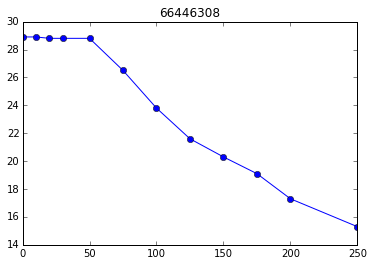

[28.9 28.9 28.8 28.8 28.8 26.5 23.8 21.6 20.3 19.1 17.3 15.3]


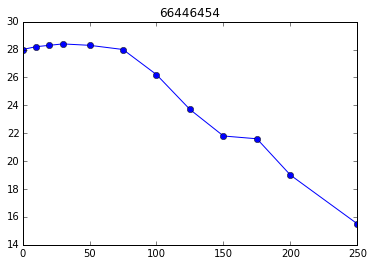

[28.0 28.2 28.3 28.4 28.3 28.0 26.2 23.7 21.8 21.6 19.0 15.5]


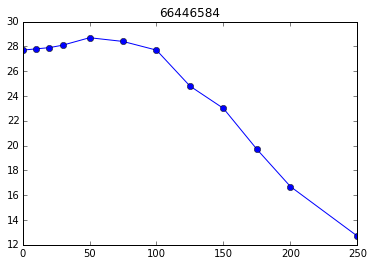

[27.7 27.8 27.9 28.1 28.7 28.4 27.7 24.8 23.0 19.7 16.7 12.7]


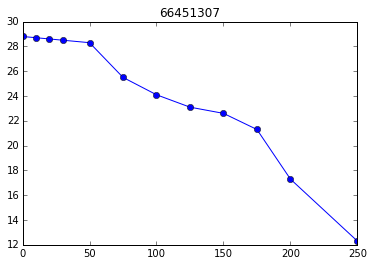

[28.8 28.7 28.6 28.5 28.3 25.5 24.1 23.1 22.6 21.3 17.3 12.3]


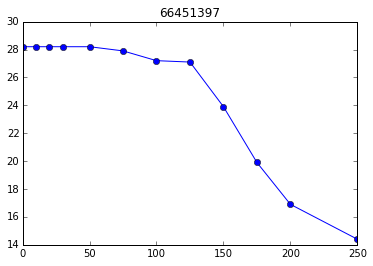

[28.2 28.2 28.2 28.2 28.2 27.9 27.2 27.1 23.9 19.9 16.9 14.4]


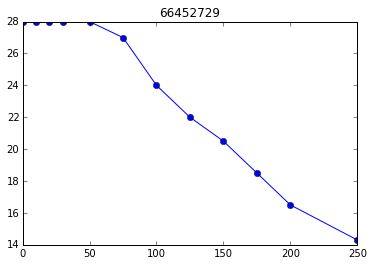

[28.0 28.0 28.0 28.0 28.0 27.0 24.0 22.0 20.5 18.5 16.5 14.3]


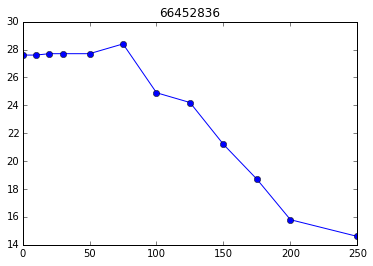

[27.6 27.6 27.7 27.7 27.7 28.4 24.9 24.2 21.2 18.7 15.8 14.6]


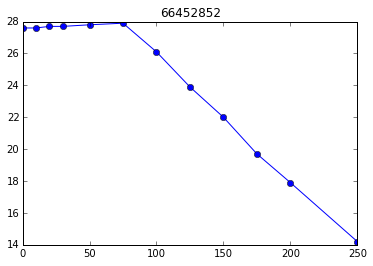

[27.6 27.6 27.7 27.7 27.8 27.9 26.1 23.9 22.0 19.7 17.9 14.2]


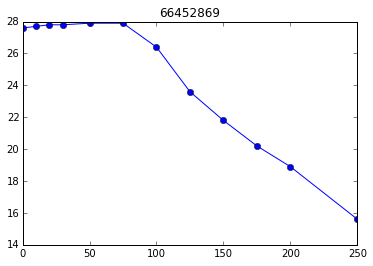

[27.6 27.7 27.8 27.8 27.9 27.9 26.4 23.6 21.8 20.2 18.9 15.6]


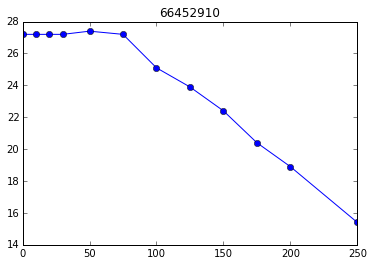

[27.2 27.2 27.2 27.2 27.4 27.2 25.1 23.9 22.4 20.4 18.9 15.4]


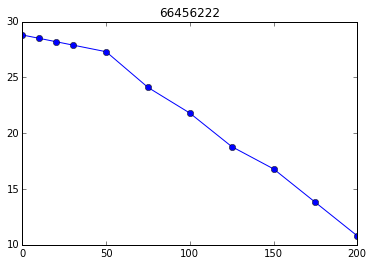

[28.8 28.5 28.2 27.9 27.3 24.1 21.8 18.8 16.8 13.8 10.8]


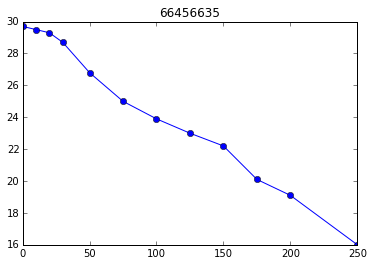

[29.7 29.5 29.3 28.7 26.8 25.0 23.9 23.0 22.2 20.1 19.1 16.0]


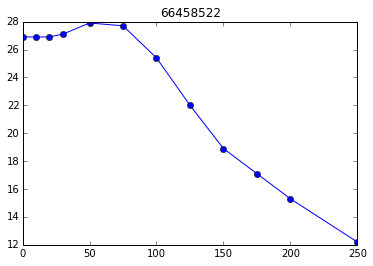

[26.9 26.9 26.9 27.1 27.9 27.7 25.4 22.0 18.9 17.1 15.3 12.2]


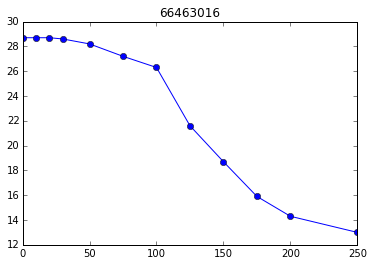

[28.7 28.7 28.7 28.6 28.2 27.2 26.3 21.6 18.7 15.9 14.3 13.0]


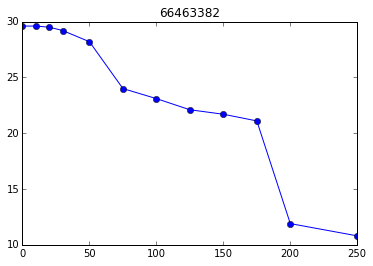

[29.6 29.6 29.5 29.2 28.2 24.0 23.1 22.1 21.7 21.1 11.9 10.8]


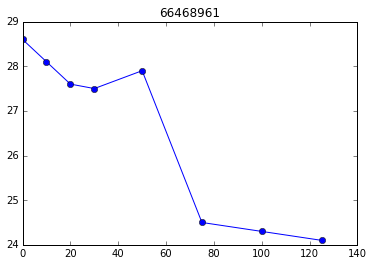

[28.6 28.1 27.6 27.5 27.9 24.5 24.3 24.1]


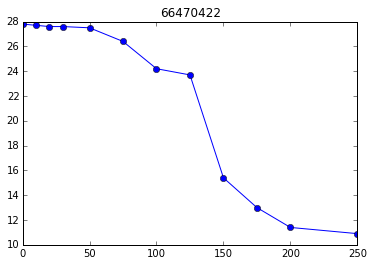

[27.8 27.7 27.6 27.6 27.5 26.4 24.2 23.7 15.4 13.0 11.4 10.9]


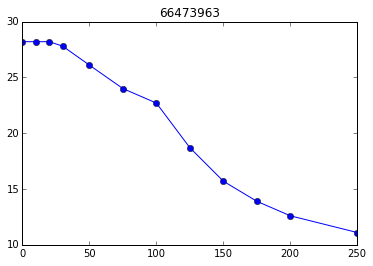

[28.2 28.2 28.2 27.8 26.1 24.0 22.7 18.7 15.7 13.9 12.6 11.1]


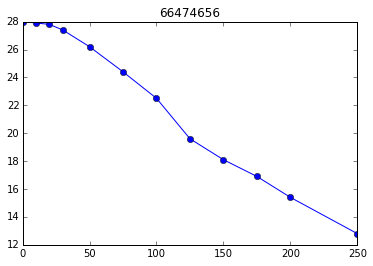

[28.0 27.9 27.8 27.4 26.2 24.4 22.5 19.6 18.1 16.9 15.4 12.8]


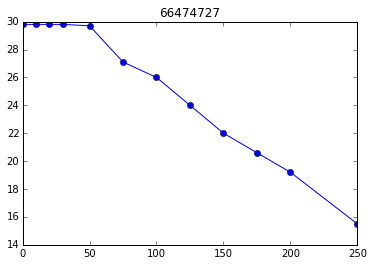

[29.8 29.8 29.8 29.8 29.7 27.1 26.0 24.0 22.0 20.6 19.2 15.5]


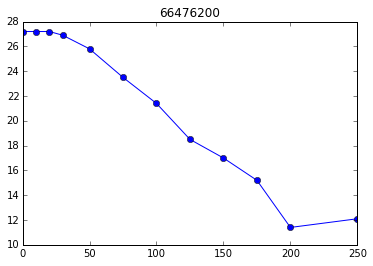

[27.2 27.2 27.2 26.9 25.8 23.5 21.4 18.5 17.0 15.2 11.4 12.1]


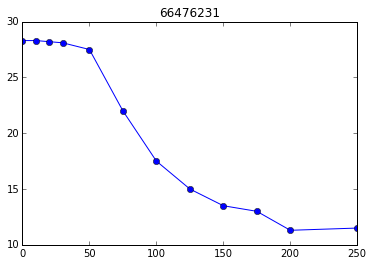

[28.3 28.3 28.2 28.1 27.5 22.0 17.5 15.0 13.5 13.0 11.3 11.5]


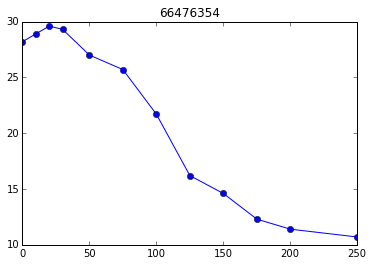

[28.2 28.9 29.6 29.3 27.0 25.7 21.7 16.2 14.6 12.3 11.4 10.7]


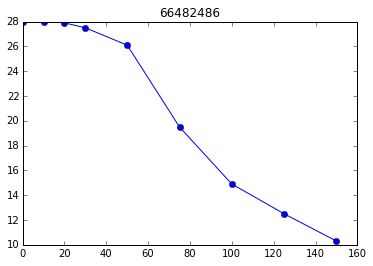

[28.0 28.0 27.9 27.5 26.1 19.5 14.9 12.5 10.3]


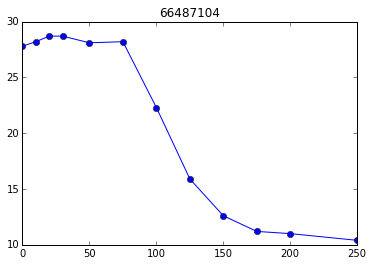

[27.8 28.2 28.7 28.7 28.1 28.2 22.3 15.9 12.6 11.2 11.0 10.4]


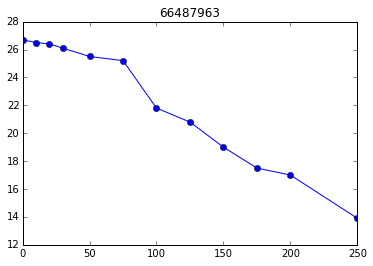

[26.7 26.5 26.4 26.1 25.5 25.2 21.8 20.8 19.0 17.5 17.0 13.9]


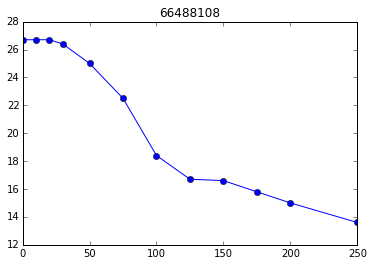

[26.7 26.7 26.7 26.4 25.0 22.5 18.4 16.7 16.6 15.8 15.0 13.6]


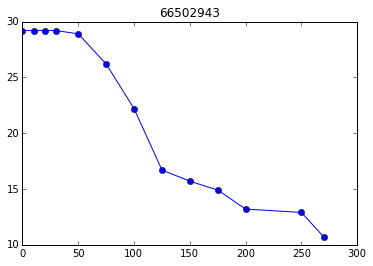

[29.2 29.2 29.2 29.2 28.9 26.2 22.2 16.7 15.7 14.9 13.2 12.9 10.7]


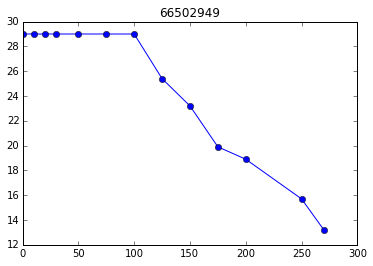

[29.0 29.0 29.0 29.0 29.0 29.0 29.0 25.4 23.2 19.9 18.9 15.7 13.2]


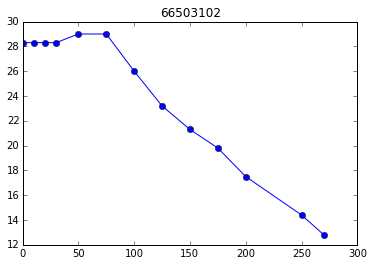

[28.3 28.3 28.3 28.3 29.0 29.0 26.0 23.2 21.3 19.8 17.5 14.4 12.8]


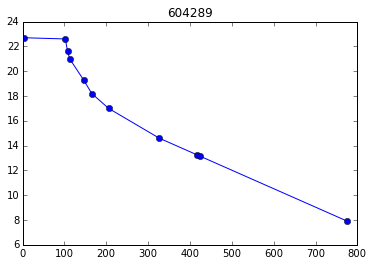

[22.7 22.6 21.6 21.0 19.3 18.2 17.0 14.6 13.26 13.1368 7.9]


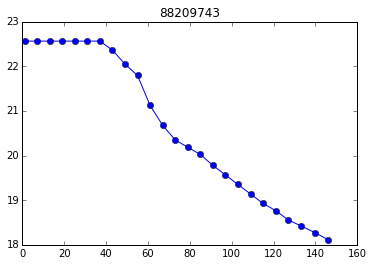

[22.563 22.563 22.563 22.563 22.563 22.563 22.563 22.362 22.048 21.793
 21.121 20.678 20.349 20.186 20.023 19.78 19.565 19.351 19.138 18.926
 18.767 18.557 18.426 18.269 18.113]


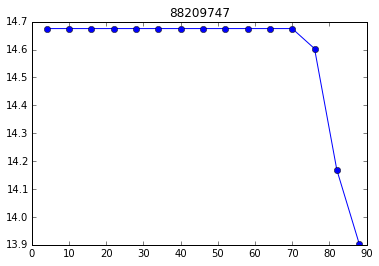

[14.675 14.675 14.675 14.675 14.675 14.675 14.675 14.675 14.675 14.675
 14.675 14.675 14.603 14.168 13.904]


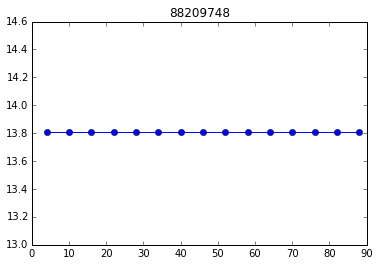

[13.808 13.808 13.808 13.808 13.808 13.808 13.808 13.808 13.808 13.808
 13.808 13.808 13.808 13.808 13.808]


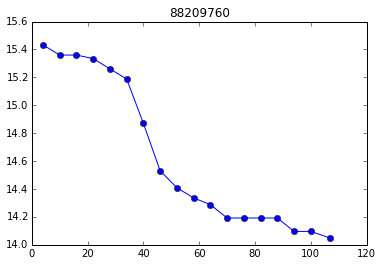

[15.433 15.36 15.36 15.335 15.261 15.188 14.87 14.53 14.409 14.336 14.288
 14.192 14.192 14.192 14.192 14.096 14.096 14.048]


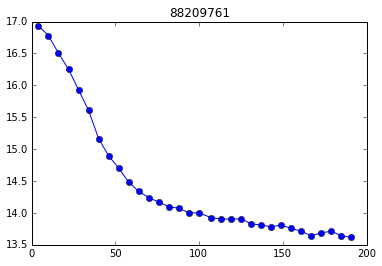

[16.932 16.781 16.503 16.253 15.928 15.606 15.163 14.894 14.7 14.482 14.336
 14.24 14.168 14.096 14.072 14.0 14.0 13.928 13.904 13.904 13.904 13.832
 13.808 13.784 13.808 13.76 13.712 13.641 13.689 13.712 13.641 13.617]


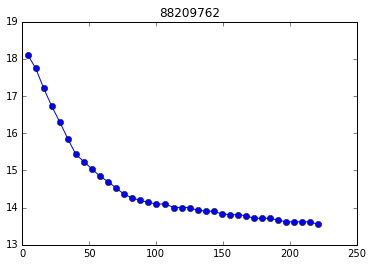

[18.113 17.751 17.212 16.73 16.303 15.854 15.433 15.237 15.041 14.846 14.7
 14.53 14.361 14.264 14.192 14.144 14.096 14.096 14.0 14.0 14.0 13.928
 13.904 13.904 13.832 13.808 13.808 13.784 13.712 13.712 13.712 13.665
 13.617 13.617 13.617 13.617 13.546]


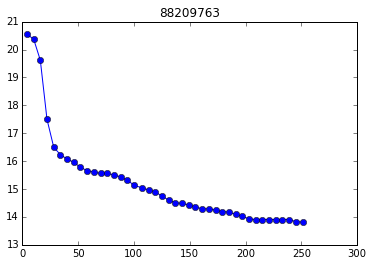

[20.541 20.377 19.618 17.494 16.503 16.227 16.078 15.953 15.779 15.656
 15.606 15.557 15.557 15.507 15.433 15.31 15.139 15.041 14.968 14.894
 14.748 14.603 14.506 14.482 14.433 14.361 14.288 14.288 14.24 14.192
 14.168 14.096 14.024 13.928 13.904 13.904 13.904 13.904 13.904 13.904
 13.832 13.808]


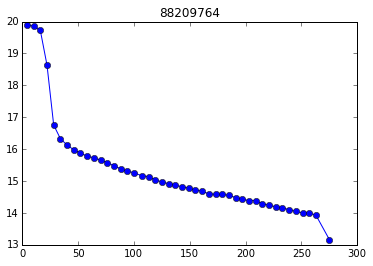

[19.888 19.861 19.726 18.636 16.755 16.328 16.128 15.978 15.879 15.779
 15.73 15.656 15.581 15.483 15.384 15.31 15.261 15.163 15.139 15.041 14.968
 14.919 14.87 14.821 14.773 14.724 14.675 14.603 14.578 14.578 14.554
 14.482 14.433 14.385 14.385 14.288 14.24 14.192 14.168 14.096 14.048 14.0
 14.0 13.928 13.166]


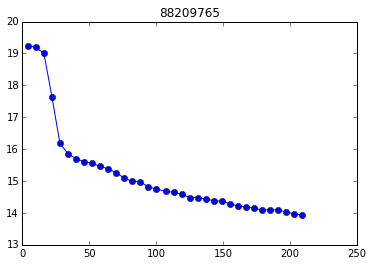

[19.244 19.191 19.005 17.648 16.177 15.854 15.705 15.606 15.557 15.458
 15.384 15.261 15.09 14.992 14.968 14.821 14.748 14.675 14.651 14.578
 14.482 14.482 14.433 14.385 14.361 14.288 14.216 14.192 14.144 14.096
 14.096 14.096 14.024 13.976 13.928]


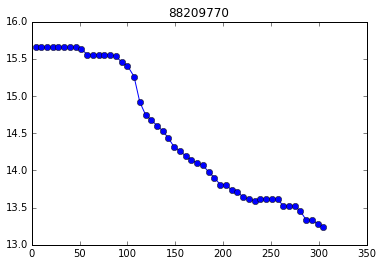

[15.656 15.656 15.656 15.656 15.656 15.656 15.656 15.656 15.631 15.557
 15.557 15.557 15.557 15.557 15.532 15.458 15.409 15.261 14.919 14.748
 14.675 14.603 14.53 14.433 14.312 14.264 14.192 14.144 14.096 14.072
 13.976 13.904 13.808 13.808 13.736 13.712 13.641 13.617 13.593 13.617
 13.617 13.617 13.617 13.522 13.522 13.522 13.45 13.332 13.332 13.284
 13.237]


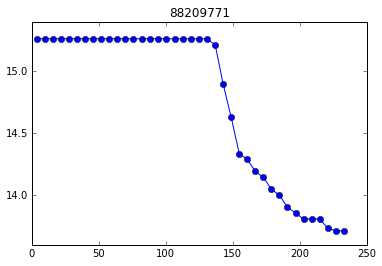

[15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261
 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261 15.261
 15.261 15.261 15.212 14.894 14.627 14.336 14.288 14.192 14.144 14.048 14.0
 13.904 13.856 13.808 13.808 13.808 13.736 13.712 13.712]


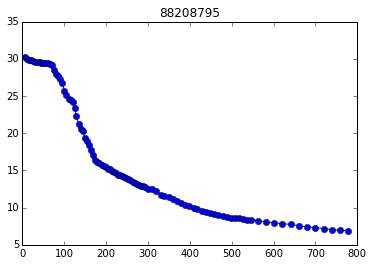

[30.272 29.916 29.837 29.772 29.706 29.615 29.563 29.511 29.459 29.42
 29.395 29.382 29.356 29.214 28.513 27.913 27.641 27.261 26.789 25.722
 25.12 24.651 24.436 24.154 23.388 22.26 21.298 20.542 20.245 19.376 18.938
 18.416 17.717 17.122 16.422 16.159 15.982 15.768 15.546 15.417 15.242
 15.141 14.967 14.839 14.603 14.403 14.322 14.214 14.097 14.007 13.872
 13.693 13.47 13.293 13.16 13.089 12.965 12.842 12.727 12.561 12.447 12.228
 11.682 11.5 11.371 11.139 10.934 10.652 10.397 10.262 10.0 9.789 9.563
 9.387 9.228 9.128 8.994 8.845 8.679 8.637 8.612 8.579 8.438 8.381 8.364
 8.257 8.075 7.952 7.853 7.73 7.575 7.427 7.321 7.182 7.044 6.93 6.881]


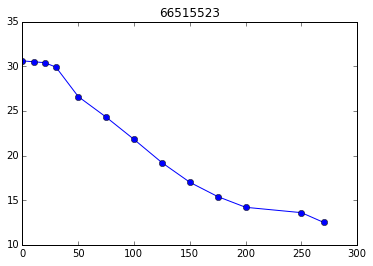

[30.6 30.5 30.4 29.9 26.6 24.3 21.8 19.2 17.0 15.4 14.2 13.6 12.5]


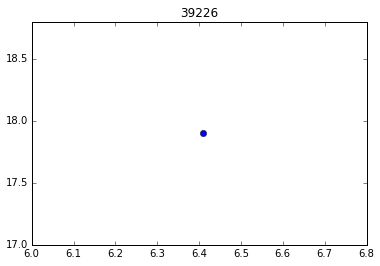

[17.9]


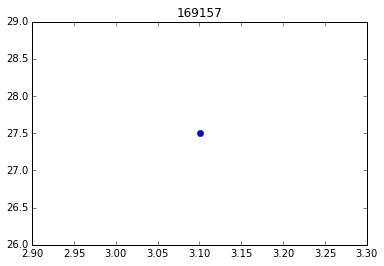

[27.5]


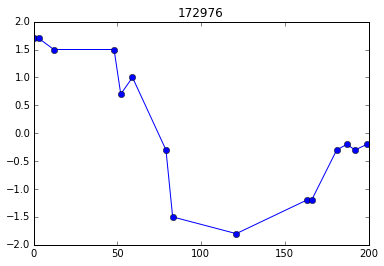

[1.7 1.7 1.5 1.5 0.7 1.0 -0.3 -1.5 -1.8 -1.2 -1.2 -0.3 -0.2 -0.3 -0.2]


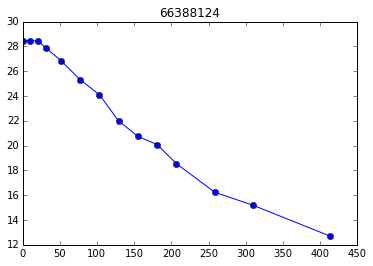

[28.45 28.44 28.45 27.888 26.85 25.309 24.1 21.979 20.75 20.079 18.548
 16.239 15.18 12.699]


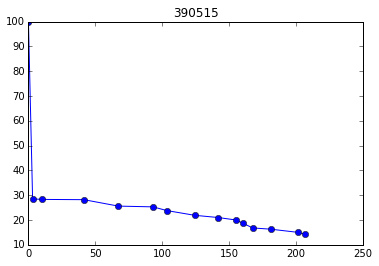

[99.9 28.5 28.3 28.2 25.6 25.3 23.8 21.9 21.0 20.0 18.6667 16.8 16.3 15.0
 14.2]


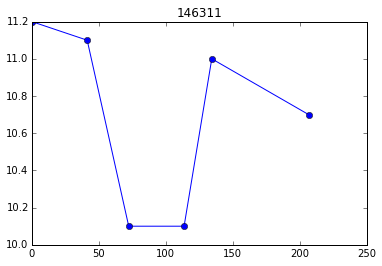

[11.2 11.1 10.1 10.1 11.0 10.7]


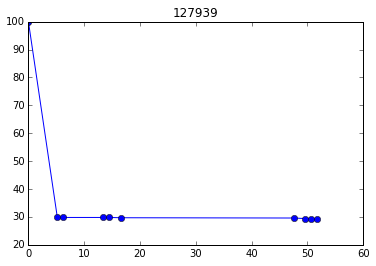

[99.9 29.9 29.8 29.8 29.8 29.7 29.6 29.4 29.2 29.1]


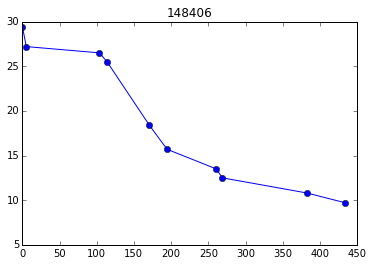

[29.4 27.2 26.5 25.5 18.4 15.7 13.5 12.5 10.8 9.7]


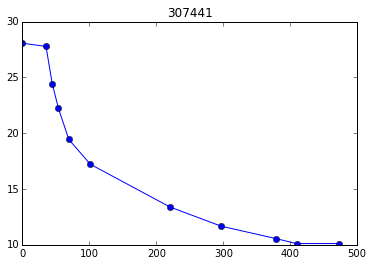

[28.06 27.78 24.44 22.22 19.44 17.22 13.39 11.67 10.56 10.11 10.11]


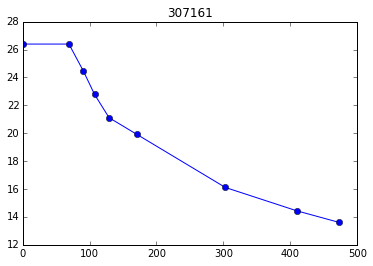

[26.39 26.39 24.44 22.78 21.11 19.9195 16.11 14.44 13.61]


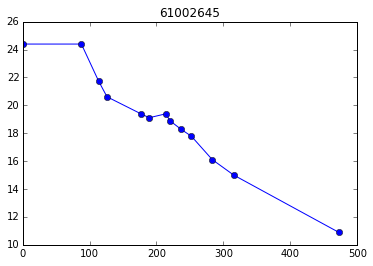

[24.39 24.39 21.72 20.61 19.39 19.11 19.39 18.89 18.28 17.78 16.11 15.0
 10.89]


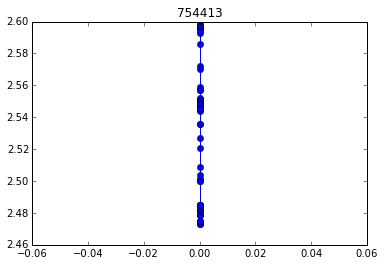

[2.599 2.596 2.596 2.597 2.597 2.597 2.593 2.594 2.586 2.572 2.57 2.559
 2.551 2.557 2.552 2.557 2.55 2.551 2.548 2.551 2.548 2.545 2.545 2.547
 2.548 2.551 2.551 2.549 2.546 2.546 2.548 2.544 2.546 2.545 2.536 2.536
 2.527 2.521 2.509 2.501 2.5 2.504 2.5 2.479 2.473 2.473 2.474 2.474 2.474
 2.475 2.474 2.475 2.479 2.481 2.479 2.481 2.482 2.483 2.485 2.485 2.485
 2.485]


In [165]:
fid = open('skim.dat')

while True:
    profile = wod.WodProfile(fid)
    
    plt.plot(profile.z(), profile.t(), marker='o')
    plt.title(profile.uid())
    plt.show()
    print profile.t()
    
    if profile.is_last_profile_in_file(fid):
        break

fid.close()

A few of these seem simple to identify in autoqc; we introduce new qc tests that flag:

 - profiles with 0 or 1 levels in them
 - profiles where all depths are the same
 - profiles where all temperatures are the same
 - profiles that have 'flat tops' - profiles with at least 4 consecutive levels of the same temperature, spread over at least 50 m.
 
Running these tests on the same set of profiles, we obtain:

```
Number of profiles tested was 12787

                       NAME OF TEST   FAILS     TPR     FPR     TNR     FNR
                  IQUOD_const_depth    1699   11.9%   13.4%   86.6%   88.1%
                   IQUOD_const_temp      12    0.9%    0.0%  100.0%   99.1%
                      IQUOD_flattop     726   16.4%    5.1%   94.9%   83.6%
                       IQUOD_nosolo       5    0.3%    0.0%  100.0%   99.7%
               RESULT OF OR OF ALL:    2431   29.0%   18.5%   81.5%   71.0%
```

The poor performance of `IQUOD_const_depth` is the most surprising - how could a profile with only one depth recorded *not* be flagged? To investigate, these are the first 20 profiles that compose the 13.4% false positive rate for `IQUOD_const_depth`:

In [147]:
def const_depth(p):
    
    d = p.z()

    qc = numpy.zeros(p.n_levels(), dtype=bool)

    # no profiles with all the same depth
    depth = Counter(d.data)    
    popular_d = depth.most_common(1)
    if popular_d[0][1] == p.n_levels():
        qc[0] = True
        return qc 
        
    return qc

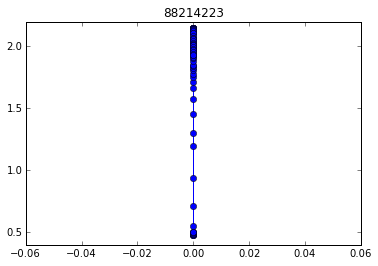

False


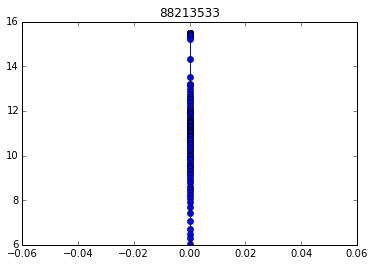

False


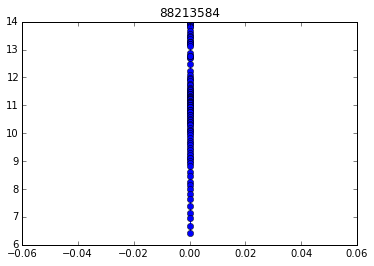

False


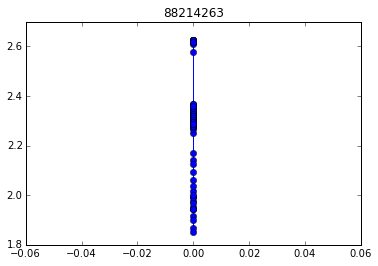

False


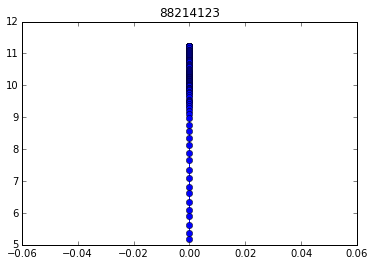

False


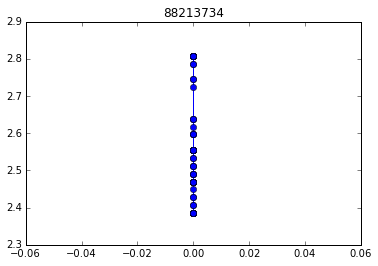

False


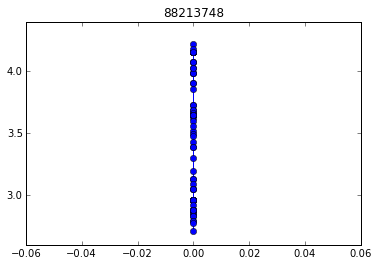

False


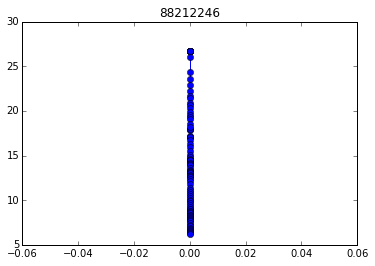

False


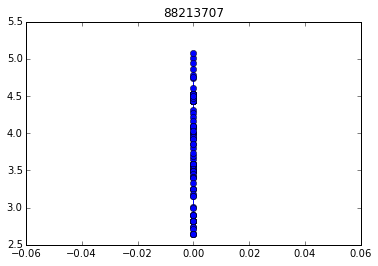

False


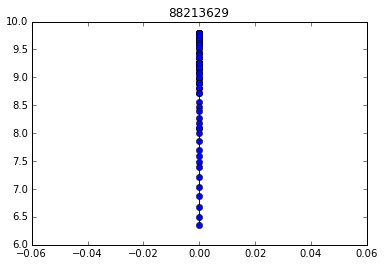

False


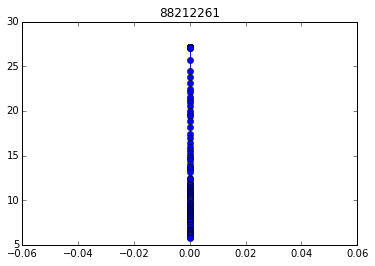

False


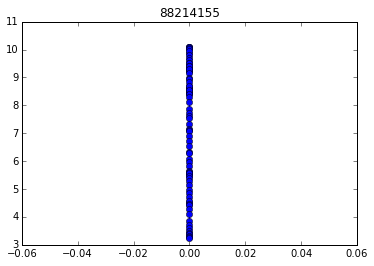

False


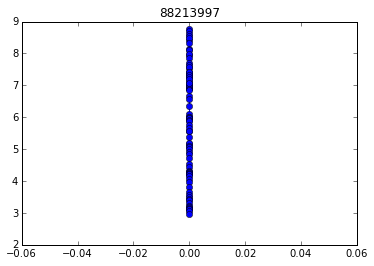

False


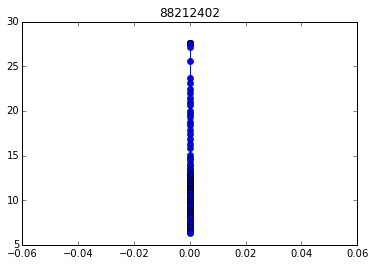

False


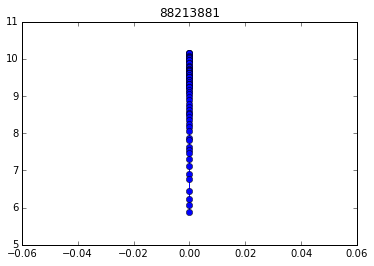

False


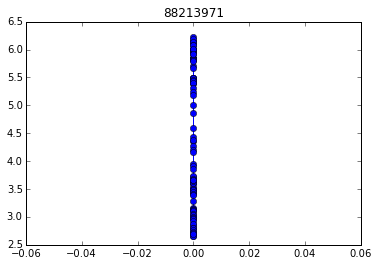

False


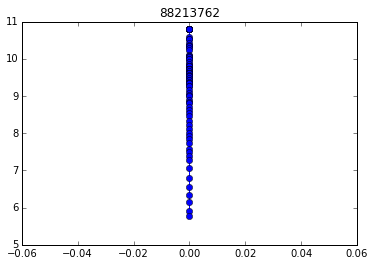

False


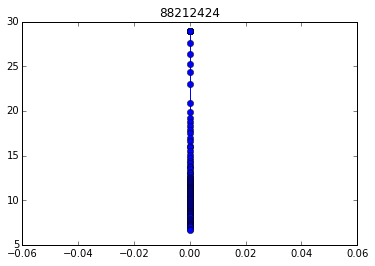

False


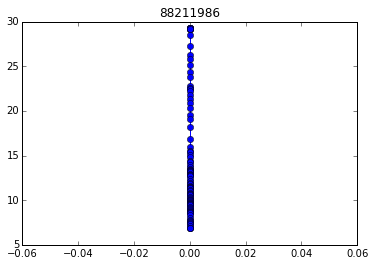

False


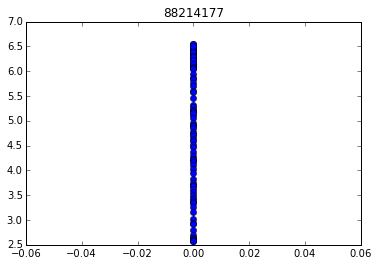

False


In [150]:
fid = open('../../../AutoQC_raw/quota/split-cruise-sorted/split-0.dat')

i = 0
while i<20:
    profile = wod.WodProfile(fid)
    qc = const_depth(profile)
    if qc.any():
        plt.plot(profile.z(), profile.t(), marker='o')
        plt.title(profile.uid())
        plt.show()
        print (profile.t_level_qc(originator=True) >= 3).any()
        i += 1
    
    if profile.is_last_profile_in_file(fid):
        break

fid.close()

There are many profiles in *quota* that don't report depth variations, but are not flagged by the temperature qc, producing the large false positive rate reported for `const_depth` above; more investigation needed.

For now, consider only the more obviously useful new qc corrections:

In [152]:
new_results = pandas.read_csv('results-newqc.csv')

results['IQUOD_nosolo'] = new_results['IQUOD_nosolo']
results['IQUOD_const_temp'] = new_results['IQUOD_const_temp']

truth = results.ix[:,1].tolist()
qctests = results.ix[:,2:].values.tolist()

In [153]:
# redo the svm

svm_classifier = svm.SVC(kernel='linear', class_weight = {0: 1, 1: 100})
svm_classifier.fit(qctests[0:trainingSize], truth[0:trainingSize])

SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 100}, coef0=0.0, degree=3,
  gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [154]:
# redo the qda

qda_classifier = QDA()
qda_classifier.fit(qctests[0:trainingSize], truth[0:trainingSize])

QDA(priors=None, reg_param=0.0)

In [155]:
svm_prediction = svm_classifier.predict(qctests[trainingSize:])
qda_prediction = qda_classifier.predict(qctests[trainingSize:])

final_prediction = [ svm_prediction[i] or qda_prediction[i] for i in range(len(svm_prediction))]
performance(truth[trainingSize:], final_prediction)

(0.9136212624584718,
 0.08637873754152824,
 0.6770675011175682,
 0.3229324988824318)

Giving us another 0.7% in true positives.